<a href="https://colab.research.google.com/github/itberrios/algotrading/blob/main/trading_agent/evaluate_notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Backtest models on real data**

This is a working notebook to backtest different models on real data.

NEED MATPLOTLIB Version 3.2.2 for cerebro plotting

Install libraries if necessary

In [ ]:
!pip install tensorflow-addons
!pip install yfinance
!pip install backtrader
!pip install pip install matplotlib==3.2.2

In [2]:
import sys
import os 
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import backtrader as bt
from datetime import datetime

Clone repo if using Colab

In [ ]:
!git clone https://github.com/itberrios/algotrading

local imports if not using Colab

In [10]:
# sys.path.append(os.path.abspath(os.path.abspath('..')))
# sys.path.append(os.getcwd())

from algotrading.data_utils import *
# from algotrading.trading_agent.Strategies import *
from algotrading.predictive_analytics.RNN.functions import transform_raw_data, last_step_accuracy, get_last_step_predictions_with_confidence
from algotrading.predictive_analytics.transformer.models.basic_transformer import TransformerModel


Get trained model paths

In [22]:
RNN_MODEL = 'algotrading/predictive_analytics/RNN/models/beta_1'
LINEAR_MODEL = 'algotrading/predictive_analytics/transformer/models/basic_linear_model_2'
TRANSFORMER_MODEL = 'algotrading/predictive_analytics/transformer/models/transformer_checkpoint'

Helper functions

In [26]:
def change_time_format(timestamp): # so that backtrader logs are correct
    reg = "%Y-%m-%d %H:%M:%S"
    time_as_str = timestamp.strftime(reg)
    reformatted_time = datetime.strptime(time_as_str, reg)
    return reformatted_time


def get_predictions_with_confidence(model, X):
    ''' used for models that only output a single target'''
    y_pred = model.predict(X)
    pred_labels = tf.argmax(y_pred, axis=-1).numpy()
    probabilities = tf.reduce_max(y_pred, axis=-1).numpy()
    return np.c_[pred_labels.reshape((-1,1)), probabilities.reshape((-1,1))]

In [94]:
# modify strategy here

from backtrader.feeds import PandasData

# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume', 'prediction', 'confidence']
    # create lines
    lines = tuple(cols)
    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

    
class MyStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_prediction = self.datas[0].prediction
        self.data_confidence = self.datas[0].confidence
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close

        # set number of shares to buy sell
        self.num_shares = 10

        # set required buy/sell probabilities
        self.buy_prob = 0.7
        self.sell_prob = 0.6
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        
        
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = str(self.datas[0].datetime.datetime())
        print(f'{dt}, {txt}')
    
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    
    def next_open(self):
        if not self.position:   # not in the market
            if self.data_prediction == 1:
                if self.data_confidence > self.buy_prob and self.broker.getcash() > self.data_open*10:
                    # buy order
                    self.log(f'BUY CREATED --- Size: {self.num_shares}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                    self.buy(size=self.num_shares)
        else:                   # in the market
            if self.data_prediction == 0 and self.data_confidence > self.sell_prob:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

##### Load Model
The model loading and inferences will be different for each model type

In [39]:
# linear model
model = tf.keras.models.load_model(LINEAR_MODEL, custom_objects={'mcc_metric' : mcc_metric})

In [48]:
# RNN
model = tf.keras.models.load_model(RNN_MODEL, custom_objects={'last_step_accuracy': last_step_accuracy})

In [95]:
from tensorflow_addons.layers import multihead_attention

custom_objects={
    'MultiHeadAttention' : multihead_attention.MultiHeadAttention,
    'TransformerModel' : TransformerModel,
    'mcc_metric' : mcc_metric}

model = tf.keras.models.load_model(TRANSFORMER_MODEL,
                                   custom_objects=custom_objects)

Load Transformer

#### Get stock data

In [96]:
ticker = 'GOOG'
START_DATE = '2022-11-1'
END_DATE = '2022-11-20'

EVAL_RANGE=24
PREDICT_RANGE=3
INTERVAL = 5

In [97]:
# for normalization
train_means = np.load('algotrading/data/transformed/{}min/{}_train_means.npy'.format(INTERVAL, ticker))
train_stds = np.load('algotrading/data/transformed/{}min/{}_train_stds.npy'.format(INTERVAL, ticker))

# get stock data
tickerData = yf.Ticker(ticker)
df = tickerData.history(interval="{}m".format(INTERVAL),  start=START_DATE, end=END_DATE)
df = df.reset_index().rename({'Datetime':'Time'}, axis=1)

# transform
data, targets, time_stamps = transform_raw_data(df, INTERVAL, EVAL_RANGE=24, 
                                      PREDICT_RANGE=3, NO_CHANGE_THRESHOLD=0.01,
                                      TRAIN_RATIO=None, train_means=train_means,
                                      train_stds=train_stds)

#### Get Predictions
Inferences will be different for each model type

In [ ]:
# linear
y_pred = get_predictions_with_confidence(model, data[:, -1, :])

In [51]:
# RNN
y_pred = get_last_step_predictions_with_confidence(model, data)

34/34 [==============================] - 2s 13ms/step


In [98]:
# Transformer
y_pred = get_predictions_with_confidence(model, data)

34/34 [==============================] - 3s 79ms/step


#### Prepare for Backtrade analysis

In [99]:
# supress setting with copy warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

# create data file for backtrade
df = df.loc[EVAL_RANGE-1:df.shape[0]-PREDICT_RANGE-1] # data points with labels
df.drop(['Dividends','Stock Splits'], axis=1, inplace=True)
df.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
df[['prediction','confidence']] = y_pred
df['Time'] = df['Time'].apply(change_time_format)
df.set_index('Time', inplace=True)

# print(df.head())

# return setting with copy warning to default 
pd.options.mode.chained_assignment = 'warn'

#### Perform Backtrade Analysis

Brokers such as IB charge about $ 0.0005 - 0.0035 per share. So we can take an average price value (with an added fudge factor) and compute an estimated commision percentage.

https://www.interactivebrokers.com/en/pricing/commissions-home.php

In [100]:
STARTING_CASH = 10000.0
COMMISSION = 0.0035 
# set margin=1 to have a fixed commission per share, else None for a percentage
MARGIN = 1

# instantiate SignalData class
data = SignalData(dataname=df)
# instantiate Cerebro, add strategy, data, initial cash, commission 
cerebro = bt.Cerebro(stdstats=True, cheat_on_open=True)
cerebro.addstrategy(MyStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(STARTING_CASH)
cerebro.broker.setcommission(commission=COMMISSION, margin=MARGIN)
# cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
final_value = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % final_value)


Starting Portfolio Value: 10000.00
2022-11-02 10:15:00, BUY CREATED --- Size: 10, Cash: 10000.00, Open: 89.83999633789062, Close: 90.1500015258789
2022-11-02 10:15:00, BUY EXECUTED --- Price: 89.84, Cost: 10.00,Commission: 0.04
2022-11-02 14:05:00, SELL CREATED --- Size: 10
2022-11-02 14:05:00, SELL EXECUTED --- Price: 90.78, Cost: 10.00,Commission: 0.04
2022-11-02 14:05:00, OPERATION RESULT --- Gross: 9.40, Net: 9.33
2022-11-02 14:25:00, BUY CREATED --- Size: 10, Cash: 10009.33, Open: 90.55010223388672, Close: 90.94499969482422
2022-11-02 14:25:00, BUY EXECUTED --- Price: 90.55, Cost: 10.00,Commission: 0.04
2022-11-02 14:30:00, SELL CREATED --- Size: 10
2022-11-02 14:30:00, SELL EXECUTED --- Price: 90.95, Cost: 10.00,Commission: 0.04
2022-11-02 14:30:00, OPERATION RESULT --- Gross: 4.00, Net: 3.93
2022-11-02 15:05:00, BUY CREATED --- Size: 10, Cash: 10013.26, Open: 89.06999969482422, Close: 89.625
2022-11-02 15:05:00, BUY EXECUTED --- Price: 89.07, Cost: 10.00,Commission: 0.04
2022-11

Compute Net Gain

$$
    net\_gain = \frac{price_{new} - price_{orig}}{price_{orig}}
$$

In [101]:
net_gain = (final_value - STARTING_CASH)/STARTING_CASH
print(f'Net Gain Percentage: {net_gain*100:.2f}%')

Net Gain Percentage: 2.46%


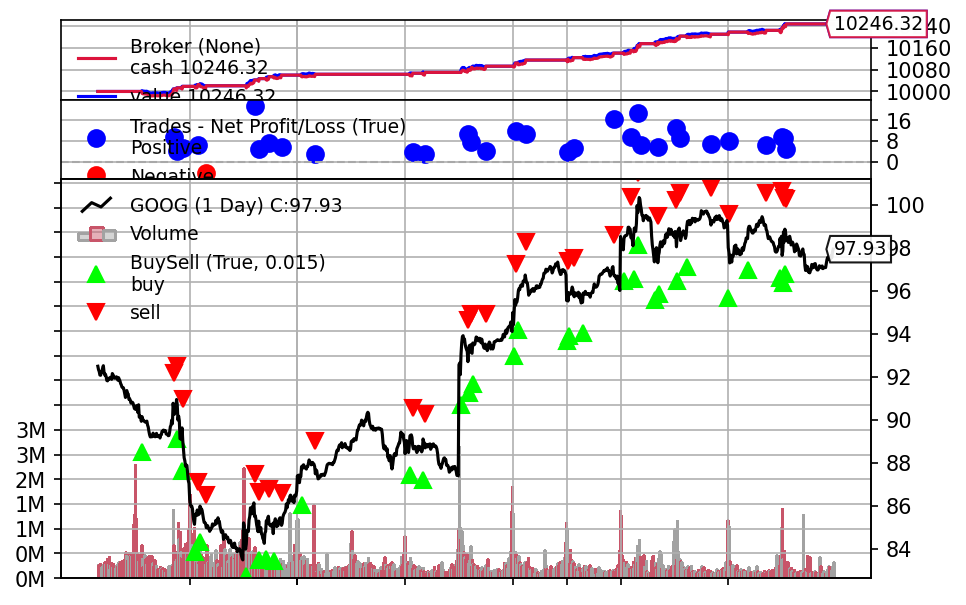

[[<Figure size 900x600 with 4 Axes>]]

In [102]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

cerebro.plot(iplot= False)